In [185]:
import numpy as np
import scipy
import scipy.stats
import scipy.ndimage
import h5py
import matplotlib.pyplot as plt
import os

from cca.data_util import CrossValidate, load_neural_data, form_lag_matrix
from cca.cov_util import calc_cross_cov_mats_from_cov, calc_cross_cov_mats_from_data
from cca import ComplexityComponentsAnalysis

RESULTS_FILENAME = "neural_decoding_results_new.hdf5"

In [186]:
def linear_decode_r2(X_train, Y_train, X_test, Y_test, decoding_window=1, offset=0):
    X_train = X_train - X_train.mean(axis=0)
    Y_train = Y_train - Y_train.mean(axis=0)
    X_test = X_test - X_test.mean(axis=0)
    Y_test = Y_test - Y_test.mean(axis=0)
    
    X_train_lags = form_lag_matrix(X_train, decoding_window)
    X_test_lags = form_lag_matrix(X_test, decoding_window)
    
    Y_train = Y_train[decoding_window // 2 :]
    Y_train = Y_train[: len(X_train_lags)]
    Y_test = Y_test[decoding_window // 2 :]
    Y_test = Y_test[: len(X_test_lags)]
    
    T_train = len(X_train_lags)
    T_test = len(X_test_lags)
    X_train_lags, X_test_lags = X_train_lags[:T_train-offset], X_test_lags[:T_test-offset]
    Y_train, Y_test = Y_train[offset:], Y_test[offset:]
    
    beta = np.linalg.lstsq(X_train_lags, Y_train, rcond=None)[0]
    Y_test_pred = np.dot(X_test_lags, beta)
    r2 = 1 - np.sum((Y_test_pred - Y_test)**2)/np.sum(Y_test**2)
    
    return r2

In [393]:
#Set this to False for safety
delete_old_file = True

#Set parameters
prefix = "/users/davidclark/Desktop/KordingData/example_data_"
postfix = ".pickle"
dset_names = ["m1"]
filenames = [prefix+name+postfix for name in dset_names]
T_vals = [10]
dim_vals = [1, 2, 3, 4, 5]
offset_vals = [0, 5, 10, 20]
num_cv_folds = 5
bin_width_s = 0.100
min_spike_count = 20
decoding_window = 3

#Save params
if delete_old_file:
    try:
        os.remove(RESULTS_FILENAME)
    except OSError:
        pass
f = h5py.File(RESULTS_FILENAME, "w-")
f.attrs["filenames"] = filenames
f.attrs["T_vals"] = T_vals
f.attrs["dim_vals"] = dim_vals
f.attrs["offset_vals"] = offset_vals
f.attrs["num_cv_folds"] = num_cv_folds
f.attrs["bin_width_s"] = bin_width_s
f.attrs["min_spike_count"] = min_spike_count
f.attrs["decoding_window"] = decoding_window
f.attrs["dset_names"] = dset_names

results_size = (len(dset_names), num_cv_folds, len(dim_vals), len(offset_vals), len(T_vals)+1)
results = f.create_dataset("results", results_size)

for dset_idx in range(len(filenames)):
    #Load data
    filename = filenames[dset_idx]
    X, Y = load_neural_data(filename, bin_width_s=bin_width_s)
    X = X[:, get_active_channels(X, window_size=300, min_count=5)]
    X = np.sqrt(X)
    X = sliding_z_score(X, window_size=300)
    X = X - X.mean(axis=0)
    Y = Y - Y.mean(axis=0)
    N = X.shape[1]
    
    X = scipy.ndimage.gaussian_filter1d(X, axis=0, sigma=1)
    
    #cov = np.cov(X.T)
    #sqrt_inv = np.linalg.inv(scipy.linalg.sqrtm(cov))
    #X = np.dot(X, sqrt_inv)
    
    print(X.shape)
        
    cv = CrossValidate(X, Y, num_cv_folds)
    for X_train, X_test, Y_train, Y_test, fold_idx in cv:
        print(fold_idx + 1)
        #Mean-center X and Y
        X_train_ctd = X_train - X_train.mean(axis=0)
        X_test_ctd = X_test - X_test.mean(axis=0)
        Y_train_ctd = Y_train - Y_train.mean(axis=0)
        Y_test_ctd = Y_test - Y_test.mean(axis=0)
        
        #Compute cross-cov mats
        """
        T_max = np.max(T_vals)
        X_lags = form_lag_matrix(X_train_ctd, T_max)
        cov = np.dot(X_lags.T, X_lags)/len(X_lags)
        cov_toep = toeplitzify(cov, N, T_max)
        min_eig = np.min(scipy.linalg.eigvalsh(cov_toep))
        if min_eig < 0:
            cov_toep += (-min_eig + 1e-4)*np.eye(N*T_max)
        #cov_toep = toeplitz_reg_threshold(cov_toep, N, T, 4)
        cross_cov_mats = calc_cross_cov_mats_from_cov(N, T_max, cov_toep)
        """
        T_max = np.max(T_vals)
        cross_cov_mats = calc_cross_cov_mats_from_data(X_train_ctd, T_max)
        
        #Do PCA
        w, V_pca_full = scipy.linalg.eigh(np.dot(X_train_ctd.T, X_train_ctd)/len(X_train_ctd))
        w, V_pca_full = w[::-1], V_pca_full[:, ::-1]
        
        #Make DCA object
        opt = ComplexityComponentsAnalysis(verbose=False)
        
        for dim_idx in range(len(dim_vals)):
            dim = dim_vals[dim_idx]
            
            #Compute PCA R2
            V_pca = V_pca_full[:, :dim]
            X_train_pca = np.dot(X_train_ctd, V_pca)
            X_test_pca = np.dot(X_test_ctd, V_pca)
            for offset_idx in range(len(offset_vals)):
                offset = offset_vals[offset_idx]
                r2_pca = linear_decode_r2(X_train_pca, Y_train, X_test_pca, Y_test, decoding_window=decoding_window, offset=offset)
                results[dset_idx, fold_idx, dim_idx, offset_idx, 0] = r2_pca
            
            for T_idx in range(len(T_vals)):
                T = T_vals[T_idx]
                opt.cross_covs = cross_cov_mats[:T]
                opt.fit_projection(d=dim)#, n_init=2)
                V_dca = opt.coef_
                
                #Compute DCA R2
                X_train_dca = np.dot(X_train_ctd, V_dca)
                X_test_dca = np.dot(X_test_ctd, V_dca)
                for offset_idx in range(len(offset_vals)):
                    offset = offset_vals[offset_idx]
                    r2_dca = linear_decode_r2(X_train_dca, Y_train, X_test_dca, Y_test, decoding_window=decoding_window, offset=offset)
                    results[dset_idx, fold_idx, dim_idx, offset_idx, T_idx+1] = r2_dca
            

(12649, 137)
1
2
3
4
5


In [62]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def decoding_fix_axes(fig_width=10, fig_height=5, hpad=0.1, wpad_edge=0.1, wpad_mid=0.1):
    fig = plt.figure(figsize=(fig_width, fig_height))
    sq_width = (1 - 2*wpad_edge - 2*wpad_mid)/3
    sq_height = sq_width * fig_width/fig_height
    ax1 = fig.add_axes((wpad_edge, hpad, sq_width, sq_height))
    ax2 = fig.add_axes((wpad_edge + sq_width + wpad_mid, hpad, sq_width, sq_height))
    ax3 = fig.add_axes((wpad_edge + 2*sq_width + 2*wpad_mid, hpad, sq_width, sq_height))
    axes = [ax1, ax2, ax3]
    return axes

def plot_delta_r2(ax, results, dset_idx=0, T_idx=0, leftmost_ax=False):
    num_cv_folds = f.attrs["num_cv_folds"]
    dset_names = f.attrs["dset_names"]
    dim_vals = f.attrs["dim_vals"]
    offset_vals = f.attrs["offset_vals"]
    n_dim = len(dim_vals)
    n_offsets = len(offset_vals)
    sem_factor = np.sqrt(1/num_cv_folds + 1/(num_cv_folds-1))
    
    pca_vals = results[dset_idx, :, :, :, 0]
    dca_vals = results[dset_idx, :, :, :, T_idx+1]
    diffs_mean = (dca_vals - pca_vals).mean(axis=0)
    diffs_sem = (dca_vals - pca_vals).std(axis=0)*sem_factor
    
    #diffs_mean /= pca_vals.mean(axis=0)
    #diffs_sem /= pca_vals.mean(axis=0)
    
    #(0, 1) = (dim, offset)

    #scatter and make errorbars
    x_vals = np.concatenate([np.arange(n_dim)+(n_dim + 3)*i for i in range(len(offset_vals))])
    colors = [default_colors[i % n_dim] for i in range(len(x_vals))]
    ax.scatter(x_vals, diffs_mean.T.flatten(), c=colors, s=20)
    ax.errorbar(x_vals, y=diffs_mean.T.flatten(), yerr=diffs_sem.T.flatten(), linestyle="None", c=colors)
    ax.axhline(0, c="black", linestyle="--")

    #set x-ticks
    x_ticks = [n_dim/2 + (n_dim + 3)*i for i in range(len(offset_vals))]
    x_tick_labels = ["$\Delta t$=" + str(offset_vals[i]) for i in range(n_offsets)]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=16)
    
    #set xlabel/title
    ax.set_xlabel("time lag [bins]", fontsize=16)
    names = {"hc": "Hippocampus", "m1": "M1/PMd", "s1": "S1"}
    ax.set_title(names[dset_names[dset_idx]], fontsize=18)
    
    if leftmost_ax:
        #set ylabel
        ax.set_ylabel("$\Delta R^2$ (DCA - PCA)", fontsize=16)
        
        #make legend
        for i in range(n_dim):
            ax.scatter(x_vals[i], diffs_mean.T.flatten()[i], c=colors[i], label="$d$="+str(dim_vals[i]), s=20)
        ax.legend(frameon=True, fontsize=10, loc="lower right", ncol=2)
        
        


ValueError: Index (1) out of range (0-0)

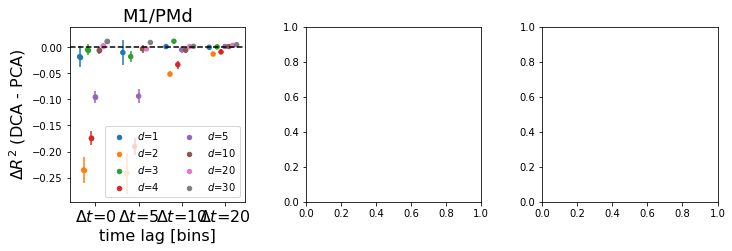

In [63]:
results = f["results"]
axes = decoding_fix_axes(fig_width=10, fig_height=5, wpad_edge=0.05, wpad_mid=0.085)
ax1, ax2, ax3 = axes
plot_delta_r2(ax1, results, dset_idx=0, leftmost_ax=True)
plot_delta_r2(ax2, results, dset_idx=1)
plot_delta_r2(ax3, results, dset_idx=2)
for ax in axes:
    #ax.set_ylim([-5, 15])
    ax.set_ylim([-0.17, 0.17])
    
#plt.savefig("decoding_fig.pdf", bbox_inches="tight")

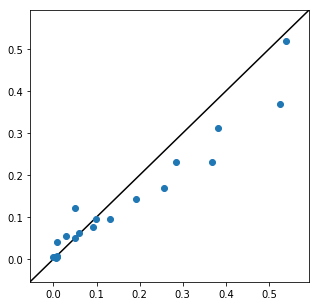

In [394]:
#f = h5py.File(RESULTS_FILENAME)
#results = f["results"]
dset_idx = 0
T_idx = 0

num_cv_folds = f.attrs["num_cv_folds"]
dset_names = f.attrs["dset_names"]
dim_vals = f.attrs["dim_vals"]
offset_vals = f.attrs["offset_vals"]
n_dim = len(dim_vals)
n_offsets = len(offset_vals)
sem_factor = np.sqrt(1/num_cv_folds + 1/(num_cv_folds-1))

pca_vals = results[dset_idx, :, :, :, 0]
dca_vals = results[dset_idx, :, :, :, T_idx+1]
diffs_mean = (dca_vals - pca_vals).mean(axis=0)
diffs_sem = (dca_vals - pca_vals).std(axis=0)*sem_factor

def square_scatter(x, y, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
    min_val = np.min(np.concatenate((x, y)))
    max_val = np.max(np.concatenate((x, y)))
    val_range = max_val - min_val
    min_val -= 0.1*val_range
    max_val += 0.1*val_range
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.scatter(x, y)
    t = np.linspace(min_val, max_val, 100)
    ax.plot(t, t, c="black", zorder=0)
    return ax
    

ax = square_scatter(pca_vals.mean(axis=0), dca_vals.mean(axis=0))
#ax.set_xlim([-0.0, 0.1])
#ax.set_ylim([-0.0, 0.1])

plt.show()

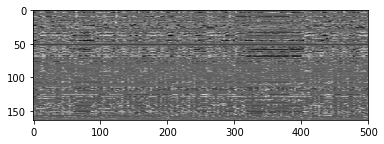

In [217]:
plt.imshow(X[:500, :].T, cmap="gray")

In [382]:
from cca.data_util import sliding_z_score, get_active_channels
dim = 1
T_pi = 1

X, Y = load_neural_data("/users/davidclark/Desktop/KordingData/example_data_m1.pickle", bin_width_s=0.100)
X = X[:, get_active_channels(X, window_size=300, min_count=5)]
X = np.sqrt(X)
X = scipy.ndimage.gaussian_filter1d(X, axis=0, sigma=1)
X = sliding_z_score(X, window_size=300)
X -= X.mean(axis=0)
X /= X.std(axis=0)
cross_cov_mats = calc_cross_cov_mats_from_data(X, 2*T_pi)
opt = ComplexityComponentsAnalysis(verbose=False)
opt.cross_covs = cross_cov_mats
opt.fit_projection(d=dim)
V_dca = opt.coef_

cov = np.dot(X.T, X)/len(X)
w, V_pca = scipy.linalg.eigh(cov)
w, V_pca = w[::-1], V_pca[:, ::-1]
V_pca = V_pca[:, :dim]

X_dca = np.dot(X, V_dca)
X_pca = np.dot(X, V_pca)

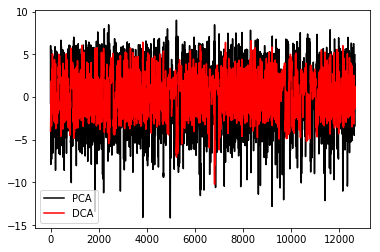

In [387]:
#beta = np.linalg.lstsq(X_dca, X_pca, rcond=None)[0]
#X_dca = np.dot(X_dca, beta)

#X_dca *= (X_pca.std(axis=0)/X_dca.std(axis=0))

t1 = 0
t2 = len(X)

plt.plot(X_pca[t1:t2, 0], label="PCA", c="black")
#plt.legend()
#plt.show()

plt.plot(X_dca[t1:t2, 0], label="DCA", c="red")
plt.legend()
plt.show()

In [384]:
def avg_deriv(x):
    return np.mean(np.diff(x)**2)/np.var(x)

x_pca, x_dca = X_pca.flatten(), X_dca.flatten()

avg_deriv(x_pca)/avg_deriv(x_dca)

3.5018423347442678

In [318]:
np.mean(np.abs(np.diff(x_pca)))/np.std(x_pca), np.mean(np.abs(np.diff(x_dca)))/np.std(x_dca)

(0.1074551471446559, 0.13423789035286204)

In [379]:
get_active_channels()

TypeError: get_active_channels() missing 3 required positional arguments: 'X', 'window_size', and 'min_count'